# Step 3: Calculate density profiles for each halo
Using the results of notebook 2, retrieve particles from the previously created haloparticles_all.h5 and calculate density profiles around the centers opf their dark matter halos. 
Store these in MyDB for later retrieval

In [1]:
import SciServer.CasJobs as cj
import os
import pandas
import math
import numpy as np
import matplotlib.pyplot as plt
import pylab as pl

import warnings
warnings.filterwarnings('ignore')

In [2]:
# this code is here to adjust the root_folder scratch storage to the user
import SciServer.Authentication as auth
USER=auth.getKeystoneUserWithToken(auth.getToken())
root_folder=f'/home/idies/workspace/Temporary/{USER.userName}/scratch/cosmodata/'

In [3]:
# determine bins for density profile. 
RadiusMin = np.log10(0.01)
RadiusMax = np.log10(2)
BinCount = 50
step=(RadiusMax-RadiusMin)/(BinCount-1)
bins = np.arange(BinCount,dtype=np.dtype('f4'))*step+RadiusMin
# calculate mean radius and volume of the bins
radius = np.exp((np.arange(BinCount-1,dtype=np.dtype('f4'))+.5)*step+RadiusMin)
volumes = (4/3) * math.pi * np.exp(bins)**3
shellVolumes = np.empty(BinCount-1, dtype=np.dtype('f8'))
for i in range(0,BinCount-1):
    shellVolumes[i] = volumes[i+1] - volumes[i]

In [4]:
# retrieve particles from HDF5 file created in previous step
# NB make sure file is not opened in other notebook. May stop kernel there...
haloStore = pandas.HDFStore(f"{root_folder}HaloParticles.h5")

In [5]:
#extract halos
halos = haloStore['Halos']

In [6]:
halos

,haloId,np,x,y,z,halfMassRadius
0,313000080000000,200039,486.280200,157.82020,388.2235,0.513466
1,465001631000000,200044,168.364700,225.70780,274.2794,0.489514
2,259001305032328,200525,368.534000,207.11040,286.1121,0.575769
3,426000068000000,200210,96.649380,458.64020,298.5108,0.530035
4,428000049000000,200123,87.790540,383.21790,345.3171,0.545141
...,...,...,...,...,...,...
97,482000079000000,209068,130.260600,85.02935,473.2986,0.424814
98,485000114000000,207711,151.466800,59.10039,479.3499,0.589006
99,485008673000000,209051,176.334400,48.27508,453.0608,0.698470
100,505000079000000,209496,59.468820,88.61140,430.0368,0.514679


In [7]:
# create a DataFrame to store the density profiles per halo
dprofs = pandas.DataFrame(columns=('haloID','r','d'))

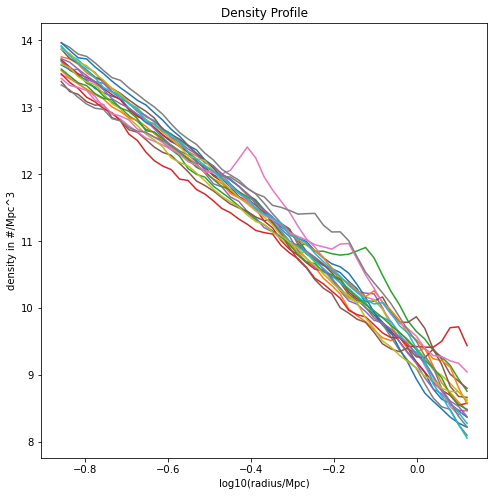

In [8]:
# define plot for showing density profiles
plt.figure(figsize=(8,8))
plt.xlabel('log10(radius/Mpc)')
plt.ylabel('density in #/Mpc^3')
plt.title('Density Profile')

# restrict to small sample for demo purposes
nmax=20
count=0
for ix,row in halos.iterrows():
    haloID=row[0]
    haloPos=row[2:5]
    groupId = f'Halo_{int(haloID)}'
    if(('/'+groupId) not in haloStore.keys()):
        print('cannot find /'+groupId)
        continue
    particles = haloStore.get(groupId)
    
    # subtract position of halo center
    ppos = particles[['x','y','z']] - haloPos

    # calculate radius for each particle
    prad = np.sqrt(ppos.x*ppos.x+ppos.y*ppos.y+ppos.z*ppos.z)
    
    # calculate histogram wrt bins defined above
    hist, bin_edges = np.histogram( np.log(prad),bins=bins)    
    
    # divide counts by volume to give density, and log density for plotting
    densities = hist/shellVolumes
    logDensities = np.log(densities)
    
    plt.plot(np.log10(radius), logDensities)
    
    df=pandas.DataFrame(columns=('haloID','r','d'))
    df['r']=radius
    df['d']=densities
    ids = np.empty(len(radius),dtype=np.dtype('i8'))
    ids.fill(haloID)
    df['haloID']=ids
    dprofs=dprofs.append(df,ignore_index=True)
    
    count+=1
    if(count >= nmax):
        break
    
#plt.show()
# save plots, first to MyScratch, then to read from there into data.
# bit of a hack. Should be possible to get data for writing directly from environment, then write to SciDrive
# will be cleaned up.
plotfile = f"{root_folder}densityprofiles.png"
pl.savefig(plotfile)



In [9]:
haloStore.close() 

**GOTO Files and check that plot is written**

**GOTO MyDB, show no density profiles table there**

In [10]:
# write density profiles to MyDB table
ddl = """CREATE TABLE halo200k_profiles(haloID bigint, r real, d real)"""
dprofs['haloID'] = dprofs['haloID'].astype('int64')
dprofs['r'] = dprofs['r'].astype('float32')
dprofs['d'] = dprofs['d'].astype('float32')

cj.uploadPandasDataFrameToTable(dprofs,"halo200k_profiles","MyDB")

True

**GOTO MyDB, show density profiles table**